# camels script testing - climate indices

In [1]:
%matplotlib inline  
import os, sys
import glob
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scripts.clim_indices as ci
import scripts.utility as util

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)


The Python version: 3.11.9
xarray 2024.6.0


## dask 

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=1, memory="10GB", queue='casper',
                  walltime='00:15:00')
cluster.scale(jobs=15)

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43785 instead
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for 

In [3]:
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/43785/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/43785/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.179:42347,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/43785/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Reading climate data

In [5]:
catchment_name = 'CONUS_HUC12' #  CONUS_HUC12 or camels
saveCSV = True
saveNetCDF = True
remap = False

In [6]:
# camels basin
#src_dir = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/climate/nldas'
#gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/gagesII_671_shp_geogr.gpkg' # HCDN_nhru_final_671.buff_fix_holes.CAMELSandTDX_areabias_fix.simp0.001.level1.gpkg
#mapping_file = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_nldas12km_to_camels.nc'
# HUC12
src_dir = '/glade/derecho/scratch/mizukami/cmip6_hydro/camels/climate/nldas/CONUS_HUC12'
gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/conus_HUC12_merit_v7b_simplified0.001.gpkg'
mapping_file = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_NLDAS12km_to_CONUS_HUC12.nc' # spatialweights_nldas12km_to_camels.nc

In [7]:
# including variables
variables = {'sw_avg':   {'scale':1,}, 
             'lw_avg':   {'scale':1,},
             'prcp_avg': {'scale':24,},
             'tair_avg': {'scale':1,},
             'q_avg':    {'scale':1,},
             'uwnd_avg': {'scale':1,},
             'vwnd_avg': {'scale':1,},
             'pres_avg': {'scale':0.001,},
            }
remap_variables = variables

In [8]:
# target catchment attribute
catch_attrs = {
    'CONUS_HUC12': ['HUCIDXint'],
    'camels': ['GAGE_ID']
}

In [9]:
def preprocess(ds):
    ds = ds[[*variables]]
    for var, meta in variables.items():
        ds[var] = ds[var]*meta['scale']
    return ds

In [10]:
%%time
print(f'Reading climate data')
a = xr.open_mfdataset(os.path.join(src_dir, f'NLDAS_200?.nc'), preprocess=preprocess, parallel=True).load()
a['tair_avg'] = a['tair_avg']-273.15

Reading climate data
CPU times: user 6.46 s, sys: 14.6 s, total: 21.1 s
Wall time: 1min 2s


## Re-mapping
- remapping 7 climate variables

In [11]:
%%time
if remap:
    a = util.regrid_mean_timeSeries(xr.open_dataset(mapping_file), a, xr.where(np.isnan(a['tair_avg'].isel(time=0)),0,1), list(variables.keys()))

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


In [12]:
ix_missing = np.where(np.all(np.isnan(a['tair_avg'].values), axis=0))[0]

## Computing climate indices

In [13]:
a['wnd_avg'] = np.sqrt(a['uwnd_avg']*a['uwnd_avg'] + a['vwnd_avg']*a['vwnd_avg'])

In [14]:
%%time
pe = ci.Penman(a['sw_avg'], a['lw_avg'], a['wnd_avg'], a['tair_avg'], a['q_avg'], a['pres_avg'])

CPU times: user 13.5 s, sys: 16.1 s, total: 29.6 s
Wall time: 31.5 s


In [15]:
b = a['prcp_avg'].mean(dim='time').to_dataset(name='p_mean')
b['pe_mean'] = pe.mean(dim='time')

In [16]:
%%time
b = xr.merge([b, ci.seasonality_index(a['tair_avg'], a['prcp_avg'])])

CPU times: user 5min 24s, sys: 4.23 s, total: 5min 29s
Wall time: 5min 51s


In [17]:
b['aridity'] = pe.mean(dim='time')/a['prcp_avg'].mean(dim='time')

In [47]:
%%time
ds1 = ci.high_p_freq_dur(a['prcp_avg']) #, dayofyear='calendar'
b['high_prec_freq'] = ds1['high_prec_freq'].mean(dim='year')
b['high_prec_dur'] = ds1['high_prec_dur'].mean(dim='year')
# Apply the mode function along the 'year' dimension
b['high_prec_timing'] = xr.apply_ufunc(
    util.mode_func,
    ds1['high_prec_timing'],
    input_core_dims=[['year']],   # Specify the dimension along which to apply the function
    vectorize=True
)

CPU times: user 7min 37s, sys: 652 ms, total: 7min 38s
Wall time: 8min 3s


In [48]:
%%time
ds2 = ci.low_p_freq_dur(a['prcp_avg'])
b['low_prec_dur'] = ds2['low_prec_dur'].mean(dim='year')
b['low_prec_freq'] = ds2['low_prec_freq'].mean(dim='year')
b['low_prec_timing'] = xr.apply_ufunc(
    util.mode_func,
    ds2['low_prec_timing'],
    input_core_dims=[['year']],   # Specify the dimension along which to apply the function
    vectorize=True
)

CPU times: user 7min 40s, sys: 620 ms, total: 7min 40s
Wall time: 8min 6s


In [ ]:
b = b.drop_vars(['high_prec_timing_test','high_prec_dur_test','high_prec_freq_test'])

## Dataset to Dataframe

In [55]:
df = b.to_dataframe()

## Save in csv or netcdf

In [56]:
if saveCSV:
    df.to_csv(f'{catchment_name}_clim_test.csv', float_format='%g')
if saveNetCDF:
    b.to_netcdf(f'{catchment_name}_clim_test.nc')

## Plotting

In [57]:
# camels shapefile
gdf_camels = util.read_shps([gpkg],catch_attrs[catchment_name])

Finished reading /glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/conus_HUC12_merit_v7b_simplified0.001.gpkg


In [58]:
gdf_camels = gdf_camels.merge(df,left_on=catch_attrs[catchment_name], right_index=True)

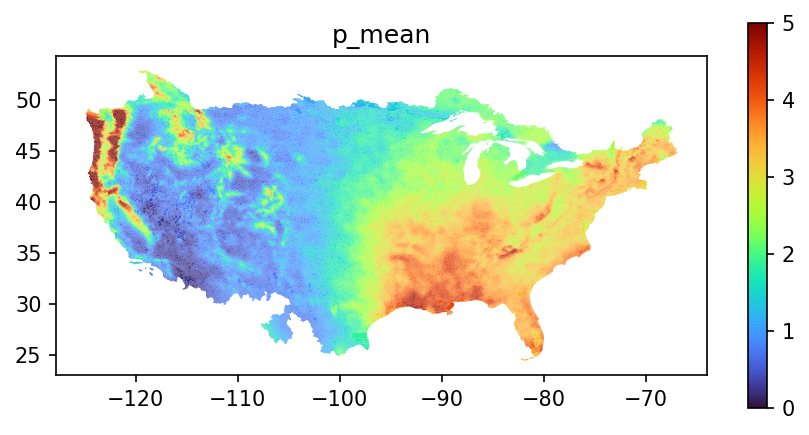

In [58]:
var_name = 'p_mean'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 5),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_clim_{var_name}.png', dpi=300)

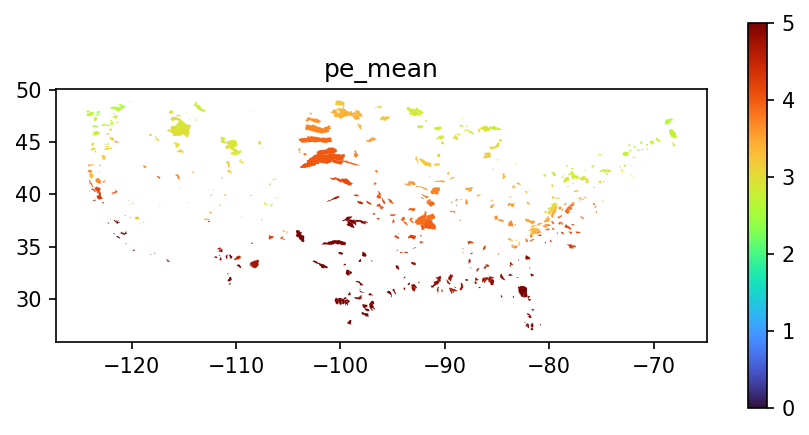

In [32]:
var_name = 'pe_mean'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 5),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_clim_{var_name}.png', dpi=300)

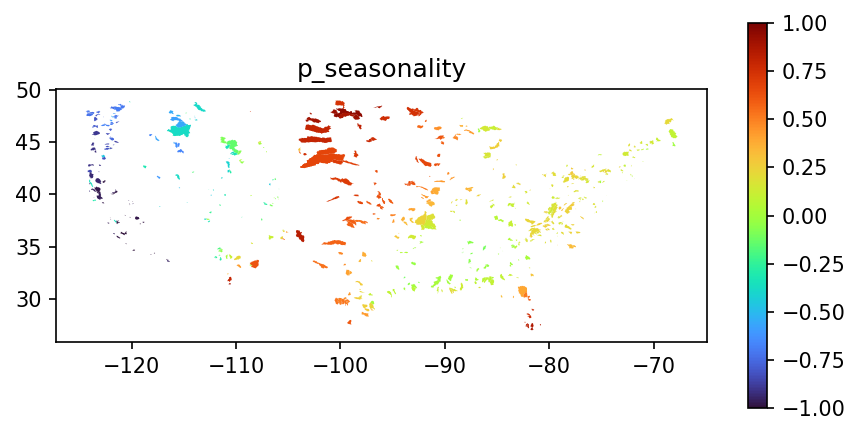

In [33]:
var_name = 'p_seasonality'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(-1, 1),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_clim_{var_name}.png', dpi=300)

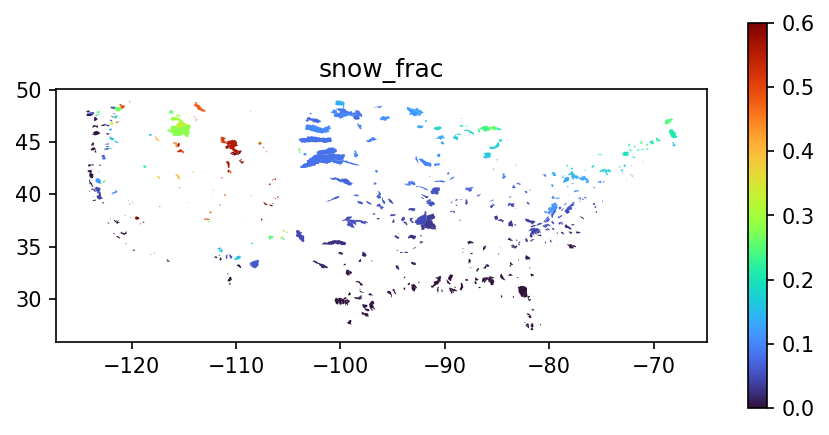

In [34]:
var_name = 'snow_frac'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo', 
                norm=colors.Normalize(0, 0.6),
                legend=True
);
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_clim_{var_name}.png', dpi=300)

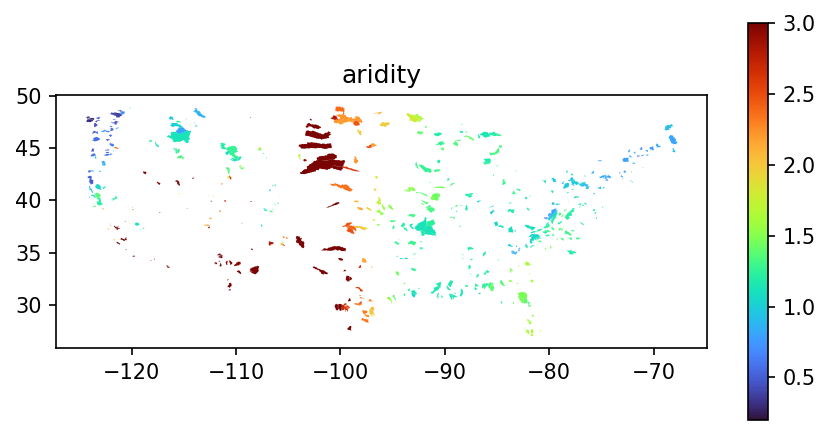

In [35]:
var_name = 'aridity'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo', 
                norm=colors.Normalize(0.20, 3.0),
                legend=True
);
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_clim_{var_name}.png', dpi=300)

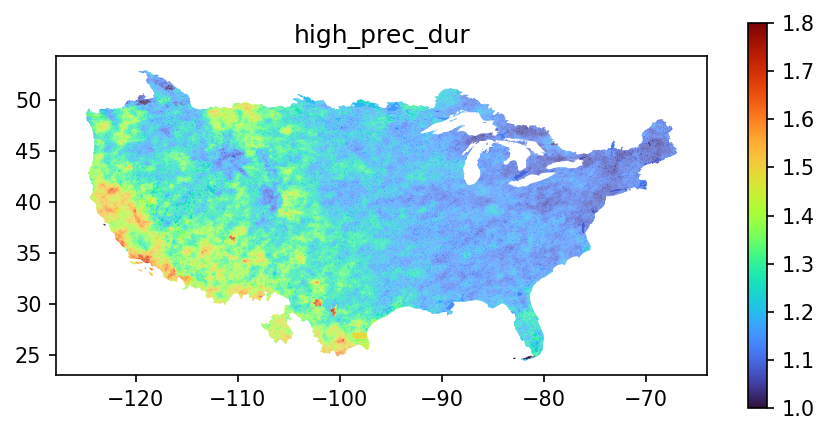

In [59]:
var_name = 'high_prec_dur'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo', 
                norm=colors.Normalize(1.0, 1.8),
                legend=True
);
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_clim_{var_name}_new.png', dpi=300)

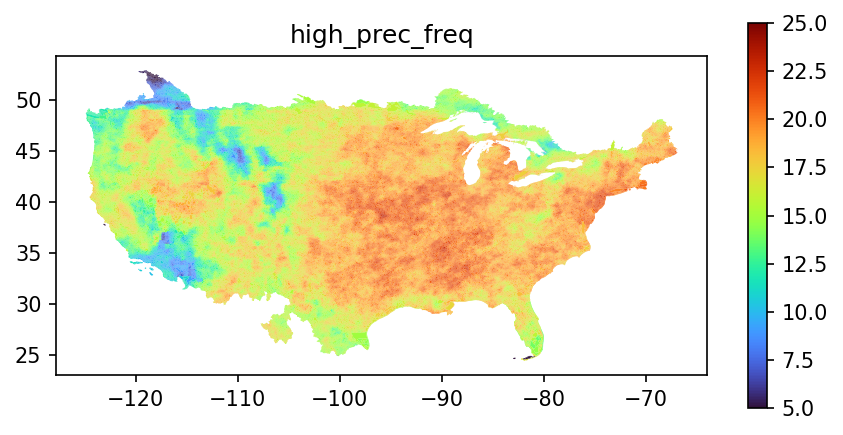

In [60]:
var_name = 'high_prec_freq'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo', 
                norm=colors.Normalize(5, 25),
                legend=True
);
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_clim_{var_name}_new.png', dpi=300)

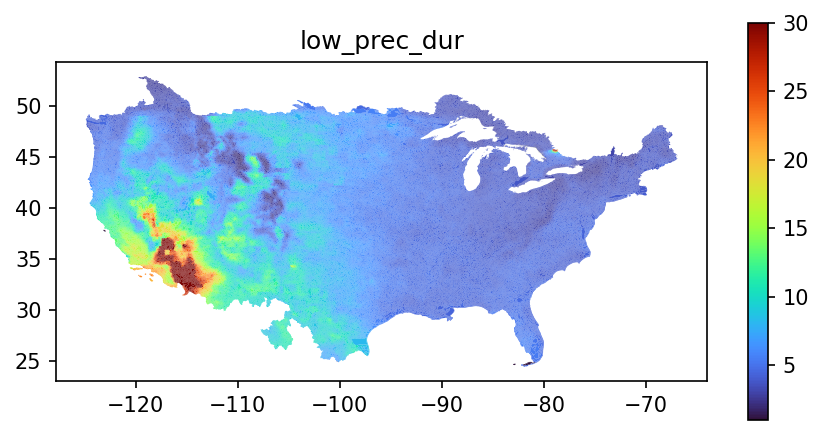

In [60]:
var_name = 'low_prec_dur'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo', 
                norm=colors.Normalize(1.0, 30),
                legend=True
);
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_clim_{var_name}_new.png', dpi=300)

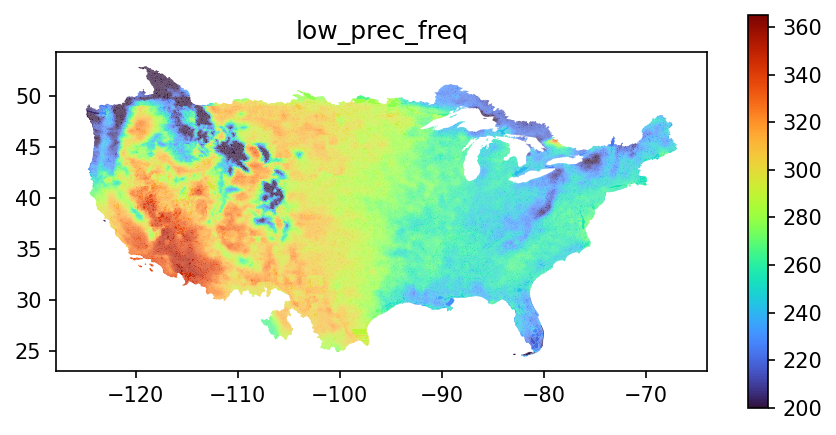

In [59]:
var_name = 'low_prec_freq'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo', 
                norm=colors.Normalize(200, 365),
                legend=True
);
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_clim_{var_name}_new.png', dpi=300)

## Some testing

In [106]:
from scipy.optimize import curve_fit

def model_tair(d, amp, phase, offset):
    return offset + amp * np.sin(2*np.pi/365*(d + phase))

def model_prec(d, amp, phase, offset):
    return offset *(1 + amp* np.sin(2*np.pi/365*(d + phase)))

In [205]:
%%time
hru = [51201090202]
epsilon = 0.00001
tt = np.arange(1,367)
t_array = a['tair_avg'].groupby("time.dayofyear").mean().sel(hru=hru).values
#t_array = a['tair_avg'].sel(time=slice('2012-01-01','2012-12-31'), hru=hru).values
p_array = a['prcp_avg'].groupby("time.dayofyear").mean().sel(hru=hru).rolling(dayofyear=30, center=True, min_periods=1).mean().values   #

for ix, hru in enumerate(hru):
    p0=[(np.max(t_array[:,ix]) - np.min(t_array[:,ix]))/2, 30, np.mean(t_array[:,ix])]
    p1=[0.5, 30, np.mean(p_array[:,ix])]
    fit_t, _ = curve_fit(model_tair, tt, t_array[:,ix], 
                  p0=p0,
                  #bounds=((-np.inf, -np.inf, np.mean(t_array[:,ix])-epsilon), (np.inf, np.inf, np.mean(t_array[:,ix])+epsilon)),
                  ftol=0.05, xtol=0.05,) #maxfev=500
    fit_p, _ = curve_fit(model_prec, tt, p_array[:,ix], 
                      p0=p1,
                      bounds=((-1, -np.inf, np.mean(p_array[:,ix])-epsilon), (1, np.inf, np.mean(p_array[:,ix])+epsilon)),
                      ftol=0.01, xtol=0.01,)    #method='trf', 
    delta_p, s_p = fit_p[0:2]
    delta_t, s_t = fit_t[0:2]
    delta_p_star = delta_p * np.sign(delta_t) * np.cos(2*np.pi*(s_p - s_t) / 365)

CPU times: user 14.8 s, sys: 7.36 s, total: 22.2 s
Wall time: 23.5 s


In [207]:
t_fit = model_tair(tt, *fit_t)

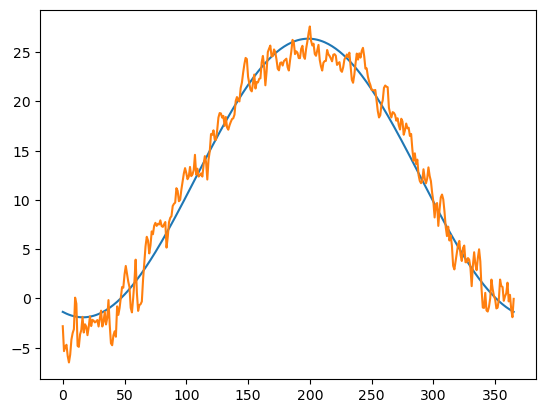

In [208]:
plt.plot(t_fit, label='after fitting')
plt.plot(t_array[:,ix])
#plt.plot(t_firt_guess, label='first guess')

In [209]:
p_firt_guess = model_prec(tt, *p1)

In [210]:
p_fit = model_tair(tt, *fit_p)

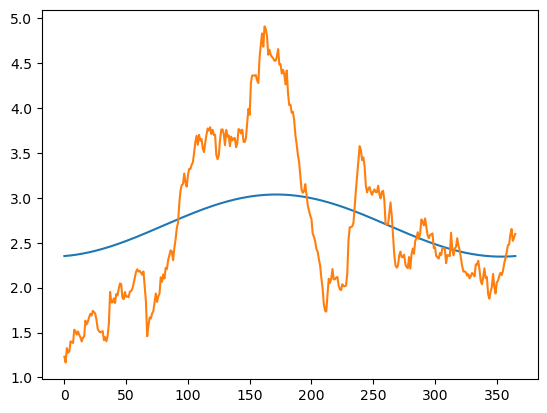

In [211]:
plt.plot(p_fit, label='after fitting')
plt.plot(p_array[:,ix])
#plt.plot(p_firt_guess, label='first guess')

In [61]:
from itertools import groupby
myCount = lambda ar: [sum(val for _ in group) for val, group in groupby(ar) if val==1]

t_axis = a['prcp_avg'].dims.index('time')
q_thresh=np.median(a['prcp_avg'].values, axis=t_axis)*5.0
years = np.arange(2010,2020)
for yr in years:
    time_slice=slice(f'{yr}-10-01',f'{yr+1}-09-30')
    datetime1 = a['time'].sel(time=time_slice)
    
    q_array = a['prcp_avg'].sel(time=time_slice).values # find annual max flow
    for sidx, hru in enumerate(a['hru'].values):
        binary_array = np.where(q_array[:,sidx] > q_thresh[sidx], 1, 0)
        count_dups = myCount(binary_array)
        break

In [22]:
from scipy.optimize import curve_fit

In [ ]:
def fit_seasonality(dayofyear, data, model, p0, bounds):
    fit_params = np.zeros((3, data.shape[1]))
    for i in range(data.shape[1]):
        fit_params[:, i], _ = curve_fit(
            model, dayofyear, data[:, i], p0=p0[:, i], bounds=bounds[:, :, i]
        )
    return fit_params

def compute_p_seasonality(temp_fit, prec_fit):
    delta_t, s_t = temp_fit[0], temp_fit[1]
    delta_p, s_p = prec_fit[0], prec_fit[1]
    delta_p_star = delta_p * np.sign(delta_t) * np.cos(2 * np.pi * (s_p - s_t) / 365)
    return delta_p_star

def compute_snow_frac(dr_tair, dr_prec, t_0=1):
    below_zero = dr_tair <= 0
    total_precip = dr_prec.sum(dim='time')
    snow_precip = dr_prec.where(below_zero).sum(dim='time')
    return (snow_precip / total_precip).fillna(0)

def seasonality_index(dr_tair, dr_prec):
    epsilon = 0.00001
    
    # Seasonal data
    dr_t_day_season = dr_tair.groupby("time.dayofyear").mean()
    dr_p_day_season = dr_prec.groupby("time.dayofyear").mean().rolling(dayofyear=30, center=True, min_periods=1).mean()
    dayofyear = dr_t_day_season.dayofyear.values
    
    # Fit temperature and precipitation curves
    def fit_all(dayofyear, t_season, p_season, t_mean, p_mean, t_amplitude, p_amplitude):
        t_p0 = np.stack([t_amplitude / 2, 30 * np.ones_like(t_mean), t_mean])
        p_p0 = np.stack([0.5 * np.ones_like(p_mean), 90 * np.ones_like(p_mean) / 360, p_mean])
        
        t_bounds = np.stack([
            [-np.inf * np.ones_like(t_mean), -np.inf * np.ones_like(t_mean), t_mean - epsilon],
            [np.inf * np.ones_like(t_mean), np.inf * np.ones_like(t_mean), t_mean + epsilon]
        ], axis=2)
        
        p_bounds = np.stack([
            [-1 * np.ones_like(p_mean), -np.inf * np.ones_like(p_mean), p_mean - epsilon],
            [1 * np.ones_like(p_mean), np.inf * np.ones_like(p_mean), p_mean + epsilon]
        ], axis=2)
        
        temp_fit = fit_seasonality(dayofyear, t_season.values, model_tair, t_p0, t_bounds)
        prec_fit = fit_seasonality(dayofyear, p_season.values, model_prec, p_p0, p_bounds)
        
        return temp_fit, prec_fit
    
    temp_fit, prec_fit = xr.apply_ufunc(
        fit_all, dayofyear, dr_t_day_season, dr_p_day_season, 
        dr_t_day_season.mean(dim='dayofyear'), dr_p_day_season.mean(dim='dayofyear'),
        dr_t_day_season.max(dim='dayofyear') - dr_t_day_season.min(dim='dayofyear'),
        dr_p_day_season.max(dim='dayofyear') - dr_p_day_season.min(dim='dayofyear'),
        input_core_dims=[["dayofyear"], ["dayofyear", "hru"], ["dayofyear", "hru"], ["hru"], ["hru"], ["hru"], ["hru"]],
        output_core_dims=[["param", "hru"], ["param", "hru"]],
        vectorize=True
    )
    
    # Compute seasonality and snow fraction
    delta_p_star = compute_p_seasonality(temp_fit, prec_fit)
    snow_frac = compute_snow_frac(dr_tair, dr_prec)
    
    # Create dataset
    ds_p_index = xr.Dataset(
        data_vars={
            "p_seasonality": (["hru"], delta_p_star),
            "snow_frac": (["hru"], snow_frac),
        },
        coords={"hru": dr_prec["hru"]}
    )
    return ds_p_index